# CS146 Assigment 3: Call center inference using Stan
# Prof. Scheffler
# Oscar Engelbrektson, Fall 2019

In [68]:
import pystan
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#  Task 1. Call center data set — exponential likelihood with a gamma prior. 
Estimate the number of calls per minute for the 13th hour of the call center data set.

### Loading the data

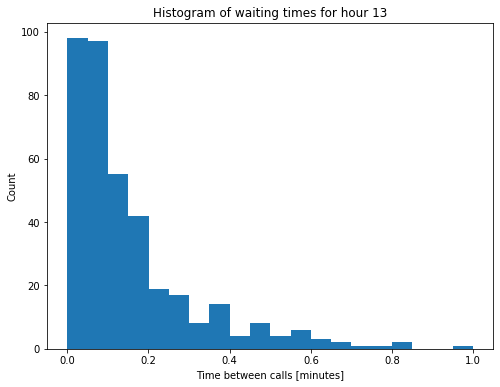

In [13]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('/Users/oscarengelbrektson/Downloads/call_center.csv')

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

#Select the 13th hour
hour_index = 13
waiting_times_hour = waiting_times_per_hour[hour_index]

# Plot histogram of waiting times for hour 13
plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Count')
plt.title(f'Histogram of waiting times for hour {hour_index}')
plt.show()

## Fitting the Stan model
As in the second assignment, I will be modelling the waiting time between calls using the exponential distribution and the prior beliefs will be modeled by the gamma distribution with alpha=1 and beta = 0.25.

In [21]:
waiting_data = {
    "alpha": 1,  # fixed prior hyperparameters for the
    "beta": 0.25,   # gamma distribution
    "waiting_times": waiting_times_hour,  # waiting time data
    "n_obs": len(waiting_times_hour) #number of observations in data
}

In [17]:
stan_code = """
data {  
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
    int<lower=1> n_obs;  // number of observations in data
    real<lower=0> waiting_times[n_obs]; // waiting time data
}

parameters {
    real<lower=0> lambda;  // average waiting time - the
                              // parameter of the exponential likelihood
}
model {
    lambda ~ gamma(alpha, beta);  // prior over lambda
    for(i in 1:n_obs) {
        waiting_times[i] ~ exponential(lambda);  // likelihood function
    }
}

"""

In [18]:
#Compile the model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6460f4331a53cdeb4c6bc2876eef8349 NOW.


In [22]:
#Sample posterior distribution over lambda
stan_results = stan_model.sampling(data = waiting_data)

## Comparing Stan results to analytical estimates from class

##### 98% confidence interval

In [25]:
#Estimate porterior 98% confidence interval over lambda using Stan
print(stan_results.stansummary(pars=['lambda'], probs=[0.01, 0.99]))

Inference for Stan model: anon_model_6460f4331a53cdeb4c6bc2876eef8349.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd     1%    99%  n_eff   Rhat
lambda   6.35  8.6e-3   0.32   5.62   7.14   1411    1.0

Samples were drawn using NUTS at Tue Oct 15 16:55:13 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


The samples from the posterior distribution over lambda from the Stan model have mean 6.35 and the 98% confidence interval is [5.62, 7.14].

The analytically derived estimates produced in class put the mean at 6.349 and the 98% confidence interval at [5.61, 7.13].

The estimates derived using the two different methods are thus substantially similar, which is to be expected as the simulation based approach should approach the analytical solutions/true values as the number grows large–which it is (4000) using Stan. 

#### Histograms of the posterior distribution

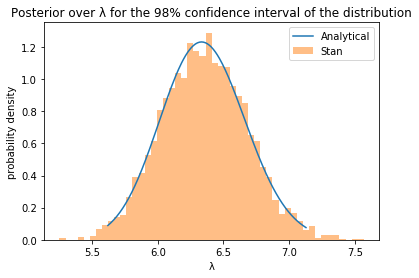

In [32]:
# Posterior samples from Stan
posterior_samples = stan_results.extract()

# Posterior from class
import scipy.stats as sts
prior_alpha = 1
prior_beta = 0.25

posterior_alpha = prior_alpha + len(waiting_times_hour)
posterior_beta = prior_beta + sum(waiting_times_hour)

posterior = sts.gamma(a=posterior_alpha, scale=1/posterior_beta)


# Plot the posteriors
#For the analytical solution
confidence_98 = (posterior.ppf(0.01), posterior.ppf(0.99))
x = np.linspace(confidence_98[0], confidence_98[1], 200)
y = posterior.pdf(x)
plt.plot(x, y, label='Analytical')

#For the stan samples
plt.hist(posterior_samples['lambda'], 
         bins=50, density=True, alpha=0.5, label='Stan')

plt.title('Posterior over λ for the 98% confidence interval of the distribution')
plt.xlabel('λ')
plt.ylabel('probability density')
plt.legend(loc=0)
plt.show()

Similarly, in the plot above, we see substantial similarity between the posterior produced using Stan and the analytically derived posterior from class. This is clear as the line showing the analytical estimates closely traces the height of each bin in the histogram of the stan samples.

# Task 2. Normal likelihood with normal-inverse-gamma prior.
Results to compute:
1. 95% posterior confidence intervals for the mean μ and variance σ of the data.
2. Take 10 samples from your posterior over μ and σ and plot the normal
distributions corresponding to them. See Task 3 in the solutions below — you should
produce a plot similar to the one you find there

In [33]:
data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])

#### Specifying the Stan Model

In [34]:
#Plugging the known values for hyperparameters derived in class, 
#and the data
dataset = {
    'mu' : 0,        
    'nu' : 0.054,    
    'alpha' : 1.12,  
    'beta' : 0.4,
    'datum' : data,
    'n_obs' : len(data)
}

In [35]:
stan_code = """

data {    //Fixed parameters as defined in dataset
    real<lower=0> mu;
    real<lower=0> nu;
    real<lower=0> alpha;  
    real<lower=0> beta; 
    int<lower=0> n_obs;
    real datum[n_obs];
}

parameters { //The distribution parameters we are trying to estimate
    real mu_mean;
    real<lower=0> sigma2;
}

model { //
    mu_mean ~ normal(mu,sqrt(sigma2/nu)); //prior over mu
    sigma2 ~ inv_gamma(alpha,beta); // prior over sigma2
    for (i in 1: n_obs){
        datum[i] ~ normal(mu_mean,sqrt(sigma2));} //likelihood
    }
"""

In [36]:
#Compiling the model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c242d16ac7bf14d192fbaac5330b193a NOW.


In [37]:
#Running the model on the data
stan_results = stan_model.sampling(data = dataset)

### Analyzing the results

#### 95% Confidence intervals over mean mu and sigma

In [38]:
print(stan_results.stansummary(pars=['mu_mean', 'sigma2'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_c242d16ac7bf14d192fbaac5330b193a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mu_mean   3.07  2.4e-3   0.14    2.8   3.07   3.33   3293    1.0
sigma2    3.63  6.3e-3   0.37   2.97    3.6   4.42   3428    1.0

Samples were drawn using NUTS at Tue Oct 15 17:59:08 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Reading the output table above, we can infer the 95% Confidence interval over Sigma2 and mu by looking at the 2.5% percentile value and the 97.5% percentile value – the lower and upper bound of the confidence interval, respectively. 

We thus have that the 95% posterior confidence interval for the mean, mu is [2.8, 3.33]. This is in good agreement with the solution from class which gave [2.800, 3.328].

As for sigma2, the 95% posterior confidence interval is [2.97, 4.42]. Also in good agreement with the results from class, [2.975, 4.396].


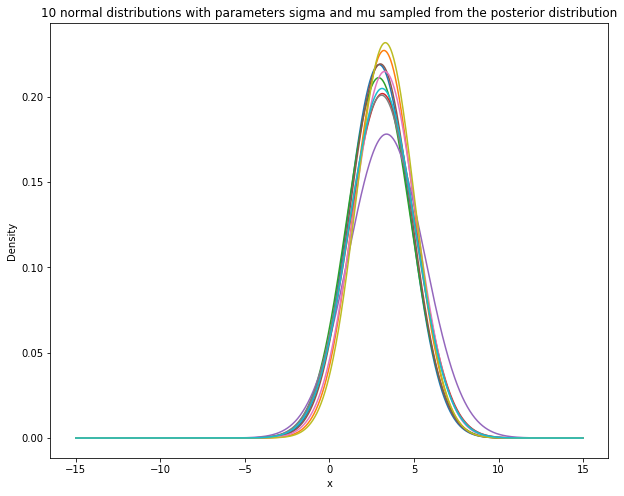

In [46]:
#Sampling the posterior distribution over our parameters using Stan
mu_samples = stan_results.extract()['mu_mean']
sigma2_samples = stan_results.extract()['sigma2']

#Draw 10 random samples from the set of samples.
import random
n_samples = 10
mu_10 = np.random.choice(mu_samples, n_samples)
sigma2_10 = np.random.choice(sigma2_samples, n_samples)

#Plot each parameter sample pair
plt.figure(figsize=(10, 8))
x = np.linspace(-15, 15, 1000)
for i in range(n_samples):
           y = sts.norm.pdf(x, loc=mu_10[i], scale=np.sqrt(sigma2_10[i]))
           plt.plot(x, y)
plt.title("10 normal distributions with parameters sigma and mu sampled from the posterior distribution")
plt.ylabel("Density")
plt.xlabel("x")
plt.show()

The conclusion that the results are substantially similar using both Stan and the conjugate priors is supported further by the above graph. Comparing it to the sample of 10 normal distributions from class, we again see a strong resemblance: the mean of the distributions seem to lie around three, the left side of the bellcurve flattens out around around -3 and the right side around 8.

# Task 3. Log-normal HRTEM data. Normal likelihood log-transformed data and using a normal-inverse-gamma prior.
Results to compute:
1. 95% posterior confidence intervals for the μ and variance σ of the log-transformed data. (Should match results under Task 3 of the solutions.)
2. Take 10 samples from your posterior over μ and σ and plot the log-normal distributions corresponding to them. See Task 5 in the solutions below — you should produce a plot similar the one you find there, but with 10 pdfs rather than one.

In [69]:
hrtem_data = np.loadtxt('/Users/oscarengelbrektson/Documents/Minerva/CS146 - Stats/hrtem.csv')
hrtem_data = np.log(hrtem_data)

In [70]:
hrtem_dataset = {
    'mu' : 2.3,
    'nu' : 0.1,
    'alpha' : 2, 
    'beta' : 5,
    'datum' : hrtem_data,
    'n_obs' : len(hrtem_data)
}

In [71]:
stan_code = """

data { //Fixed parameters as defined in dataset
    real<lower=0> mu;
    real<lower=0> nu;
    real<lower=0> alpha;  
    real<lower=0> beta;
    int<lower=0> n_obs;
    real datum[n_obs]; 
}

parameters {
    real mu_mean; //parameters we are trying to estimate
    real<lower=0> sigma2; 
}

model {
    mu_mean ~ normal(mu, sqrt(sigma2/nu)); //prior over mu
    sigma2 ~ inv_gamma(alpha, beta);  //prior over sigma2
    for (i in 1: n_obs){
        datum[i] ~ normal(mu_mean, sqrt(sigma2));} //likelihood
    }
"""

In [72]:
#Compiling the model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7d9ea9c4c7994fc9a5a7be8f12dbb09c NOW.


In [73]:
#Running the model on the data
stan_results = stan_model.sampling(data = hrtem_dataset)

### Analyzing the results

#### 95% Confidence intervals over mean mu and sigma

In [74]:
print(stan_results.stansummary(pars=['mu_mean', 'sigma2'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_7d9ea9c4c7994fc9a5a7be8f12dbb09c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mu_mean   1.89  5.2e-4   0.03   1.83   1.89   1.95   3746    1.0
sigma2     0.5  5.1e-4   0.03   0.44    0.5   0.56   3735    1.0

Samples were drawn using NUTS at Fri Oct 18 20:28:35 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Using the same methodology as in the previous task, we have the following:
The 95% posterior confidence interval for the mean, mu is [1.83, 1.95]. Identical, up to two decimals at least, to the solution from class which gave [1.83, 1.95].

As for sigma2, the 95% posterior confidence interval is [0.44, 0.56]. Identical, up to two decimals at least, the results from class, [0.44, 0.56].


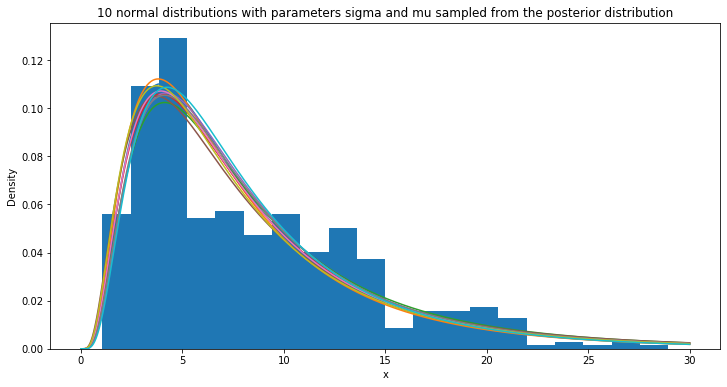

In [84]:
#Sampling the posterior distribution over our parameters using Stan
mu_samples = stan_results.extract()['mu_mean']
sigma2_samples = stan_results.extract()['sigma2']

#Draw 10 random samples from the set of samples.
import random
n_samples = 10
mu_10 = np.random.choice(mu_samples, n_samples)
sigma2_10 = np.random.choice(sigma2_samples, n_samples)

#Plot each parameter sample pair
plt.figure(figsize=(12,6))
x = np.linspace(0, 30, 1000)
for i in range(n_samples): #Exponentiate to undo the log, sqrt the variance to get the standard dev
           y = sts.lognorm.pdf(x, np.sqrt(sigma2_10[i]), scale=np.exp(mu_10[i])) 
           plt.plot(x, y)
plt.hist(np.exp(hrtem_data), density=True, bins=20)
plt.title("10 normal distributions with parameters sigma and mu sampled from the posterior distribution")
plt.ylabel("Density")
plt.xlabel("x")
plt.show()

Similar to all cases previous, this graph is essentially indistinguishable from the one generated using a different methodology in class. Of course the histogram is literally identical as it is generated from the same data.

#confidenceintervals. For each inference problem I calculate, with clearly articulated methods and annotated code, and commincate confidence intervals for different parameters.
#distributions. Throughout the process of Bayesian Inference, we make modelling choices around what probability distributions are appropriate for representing our prior beliefs and/or modelling the data. Also , I didn't tag this in the last assignment, but I reasoned quite thoroughly as to why specific distributions were chosen for these problems. I think the joint effort warants a grade in this HC. 